In [1]:
!nvidia-smi

Fri Aug 18 11:26:53 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.10              Driver Version: 535.86.10    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          On  | 00000000:17:00.0 Off |                    0 |
| N/A   34C    P0              53W / 300W |      2MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
import os
from pathlib import Path
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
from typing import Any
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score

import torch.nn
from pytorch_lightning.core.mixins import HyperparametersMixin
from torch import Tensor as T
from torch import nn
from torch.nn.functional import normalize
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch_geometric.data import Data
from pytorch_lightning import Trainer

from pytorch_lightning.callbacks import Callback, TQDMProgressBar

from gnn_tracking.utils.loading import TrackingDataModule
from gnn_tracking.training.callbacks import PrintValidationMetrics
from gnn_tracking.training.base import TrackingModule
from gnn_tracking.models.graph_construction import GraphConstructionFCNN
from gnn_tracking.utils.lightning import obj_from_or_to_hparams
from gnn_tracking.models.mlp import MLP

In [3]:
class NoiseModel(nn.Module, HyperparametersMixin):
    def __init__(self, in_dim, depth, hidden_dim):
        super().__init__()
        self.save_hyperparameters()

        layers = [nn.Linear(in_dim, hidden_dim), nn.ReLU()]
        for _ in range(depth - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, 1))  # Output layer
        
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

In [25]:
class NoiseModule(TrackingModule):
    def __init__(
        self,
        *,
        loss_fct: BCEWithLogitsLoss,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.loss_fct = loss_fct
        self.logits = []
        self.true_labels = []
    
    def get_losses(self, out: Any, true_hits: T) -> T:
        return self.loss_fct(out, true_hits)

    def sigmoid_and_threshold(self, logits, threshold=0.5):
        probs = torch.sigmoid(logits)
        return (probs >= threshold).float()
    
    def get_true_hits(self, data: Data):
        true_hits = (data.particle_id != 0) # & (data.pt >= 0.5)
        true_hits = true_hits.unsqueeze(dim=-1).type(torch.float64)
        return true_hits
    
    def training_step(self, batch: Data, batch_idx: int) -> T | None:
        out = self(batch.x)
        true_hits = self.get_true_hits(batch)
        
        loss = self.get_losses(out, true_hits)
        
        self.log_dict(
            {'BCELoss_train': float(loss)},
            prog_bar=True,
            on_step=True,
            batch_size=self.trainer.train_dataloader.batch_size,
        )
        
        return loss
    
    def validation_step(self, batch: Data, batch_idx: int):
        out = self(batch.x)
        true_hits = self.get_true_hits(batch)
        loss = self.get_losses(out, true_hits)
        
        self.log_dict_with_errors(
           {'BCELoss': float(loss)}, batch_size=self.trainer.val_dataloaders.batch_size
        )
        
        self.logits.append(out.squeeze())
        self.true_labels.append(true_hits.squeeze())
        
        preds = self.sigmoid_and_threshold(out)
        true_labels = true_hits.cpu().numpy()
        predicted_labels = preds.cpu().numpy()

        accuracy = accuracy_score(true_labels, predicted_labels)
        recall = recall_score(true_labels, predicted_labels)

        self.log('val_accuracy', accuracy, on_step=False, on_epoch=True)
        self.log('val_recall', recall, on_step=False, on_epoch=True)
    
    def on_validation_epoch_end(self) -> None:
        self._log_errors()
        
        # Compute ROC curve
        logits = torch.cat(self.logits, dim=0)
        true_labels = torch.cat(self.true_labels, dim=0)
        self.logits = []
        self.true_labels = []

        probabilities = torch.sigmoid(logits).cpu().numpy()
        true_labels = true_labels.cpu().numpy()

        fpr, tpr, _ = roc_curve(true_labels, probabilities)
        
        plt.figure()
        plt.plot(fpr, tpr)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.show()

In [26]:
val_dir = Path("/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v6/part_9")
assert val_dir.is_dir()

In [27]:
train_dirs = []
train_dir = Path("/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v6/")
for i in range(1,9):
    d = os.path.join(train_dir, f"part_{i}")
    if os.path.isdir(d):
        train_dirs.append(d)

In [28]:
dm = TrackingDataModule(
    train=dict(
        dirs=train_dirs,
        batch_size=1
    ),
    val=dict(
        dirs=[val_dir],
        stop=20,
    ),
    # could also configure a 'test' set here
)

In [29]:
# This is called by the Trainer automatically and sets up the datasets
dm.setup(stage="fit")  # 'fit' combines 'train' and 'val'
# Now the datasets are available:
dm.datasets

[11:34:25] INFO: DataLoader will load 7743 graphs (out of 7743 available).
[11:34:25] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v6/part_1/data21000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v6/part_8/data28999_s0.pt
[11:34:25] INFO: DataLoader will load 20 graphs (out of 1000 available).
[11:34:25] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v6/part_9/data29000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v6/part_9/data29019_s0.pt


{'train': TrackingDataset(7743), 'val': TrackingDataset(20)}

In [30]:
model =  NoiseModel(in_dim=14, depth=6, hidden_dim=256)
nmodel = NoiseModule(
        model=model,
        loss_fct=BCEWithLogitsLoss(),
        optimizer=partial(torch.optim.Adam, lr=0.001),
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
[11:34:26] INFO: DataLoader will load 7743 graphs (out of 7743 available).
[11:34:26] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v6/part_1/data21000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v6/part_8/data28999_s0.pt
[11:34:26] INFO: DataLoader will load 20 graphs (out of 1000 available).
[11:34:26] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v

Sanity Checking: 0it [00:00, ?it/s]

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


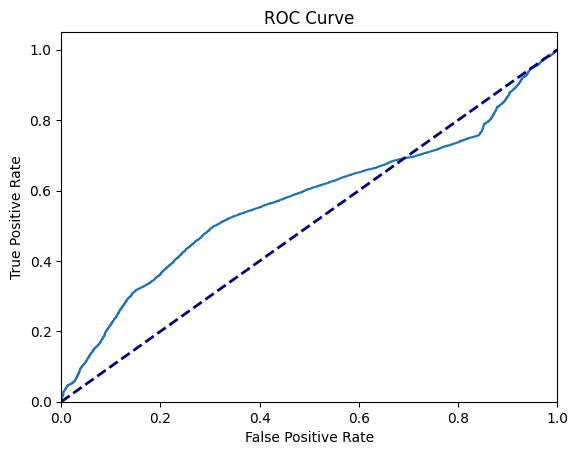

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

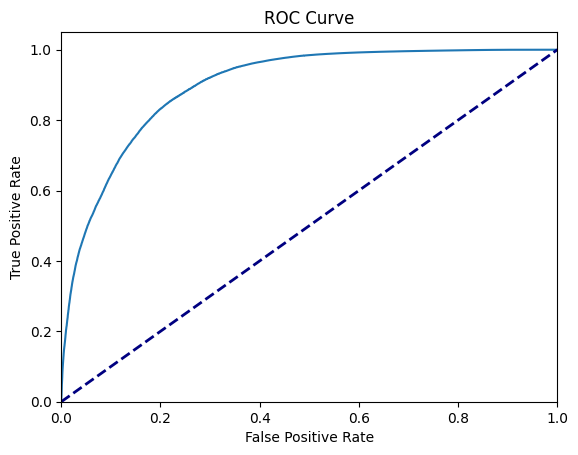

         Validation epoch=0          
┏━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric        ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ BCELoss       │ 0.14251 │ 0.00248 │
│ BCELoss_train │ 0.15848 │     nan │
│ val_accuracy  │ 0.95492 │     nan │
│ val_recall    │ 0.99122 │     nan │
└───────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

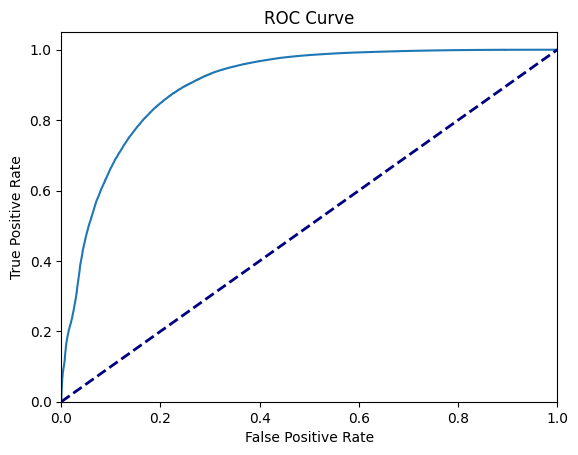

         Validation epoch=1          
┏━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric        ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ BCELoss       │ 0.14078 │ 0.00257 │
│ BCELoss_train │ 0.13768 │     nan │
│ val_accuracy  │ 0.95512 │     nan │
│ val_recall    │ 0.99078 │     nan │
└───────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

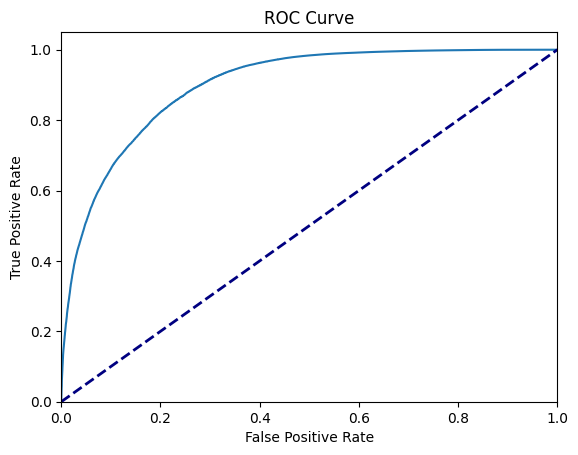

         Validation epoch=2          
┏━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric        ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ BCELoss       │ 0.14292 │ 0.00267 │
│ BCELoss_train │ 0.13814 │     nan │
│ val_accuracy  │ 0.95451 │     nan │
│ val_recall    │ 0.99146 │     nan │
└───────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

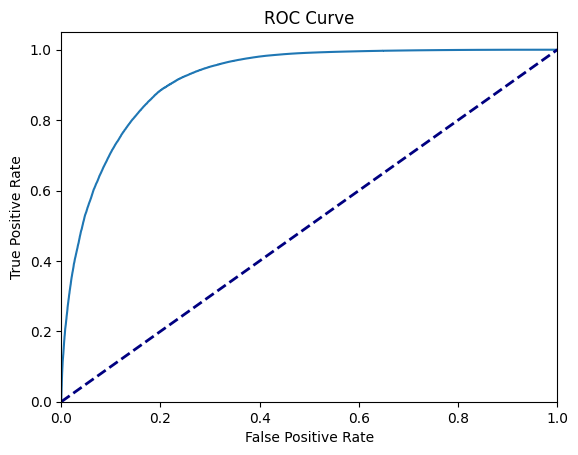

         Validation epoch=3          
┏━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric        ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ BCELoss       │ 0.12768 │ 0.00232 │
│ BCELoss_train │ 0.13902 │     nan │
│ val_accuracy  │ 0.96014 │     nan │
│ val_recall    │ 0.99195 │     nan │
└───────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

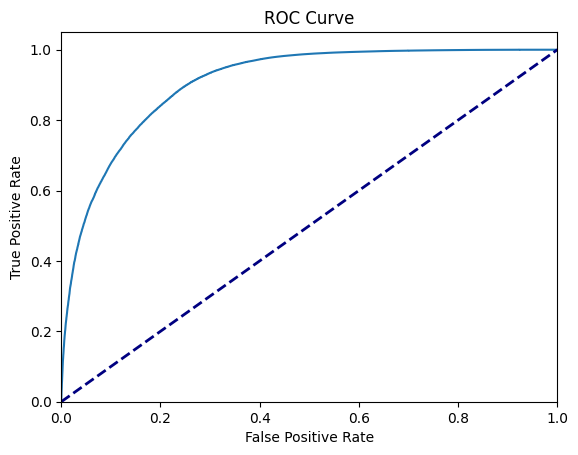

         Validation epoch=4          
┏━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric        ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ BCELoss       │ 0.13584 │ 0.00242 │
│ BCELoss_train │ 0.12663 │     nan │
│ val_accuracy  │ 0.95743 │     nan │
│ val_recall    │ 0.99206 │     nan │
└───────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

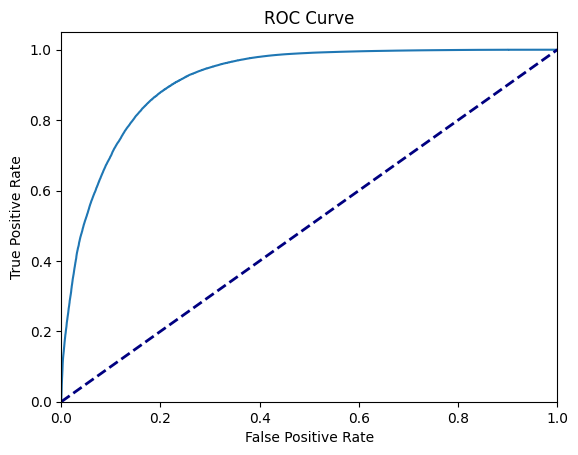

         Validation epoch=5          
┏━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric        ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ BCELoss       │ 0.12901 │ 0.00232 │
│ BCELoss_train │ 0.13651 │     nan │
│ val_accuracy  │ 0.95977 │     nan │
│ val_recall    │ 0.98955 │     nan │
└───────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

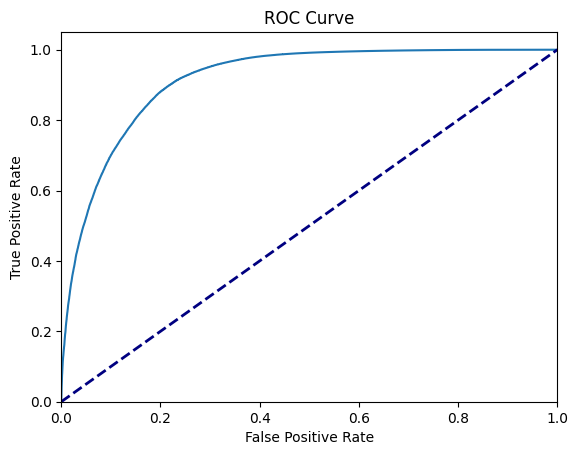

         Validation epoch=6          
┏━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric        ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ BCELoss       │ 0.12807 │ 0.00223 │
│ BCELoss_train │ 0.12788 │     nan │
│ val_accuracy  │ 0.96020 │     nan │
│ val_recall    │ 0.99030 │     nan │
└───────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

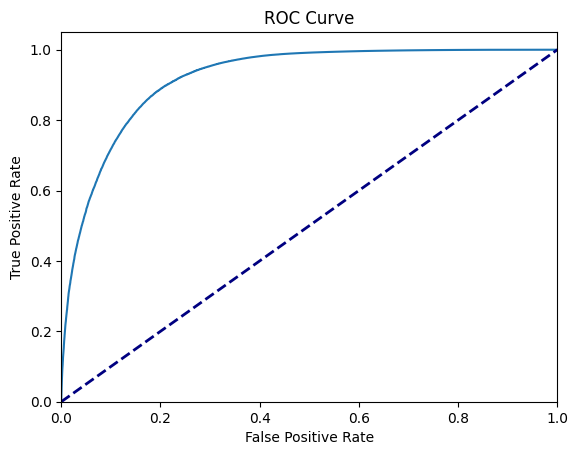

         Validation epoch=7          
┏━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric        ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ BCELoss       │ 0.12618 │ 0.00231 │
│ BCELoss_train │ 0.12319 │     nan │
│ val_accuracy  │ 0.96053 │     nan │
│ val_recall    │ 0.99111 │     nan │
└───────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

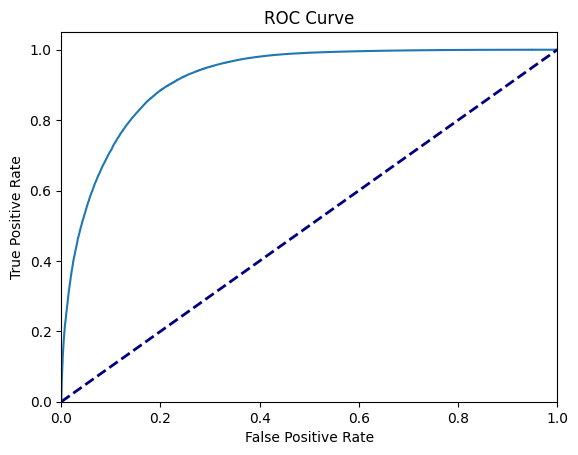

         Validation epoch=8          
┏━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric        ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ BCELoss       │ 0.12720 │ 0.00232 │
│ BCELoss_train │ 0.12675 │     nan │
│ val_accuracy  │ 0.96021 │     nan │
│ val_recall    │ 0.99117 │     nan │
└───────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

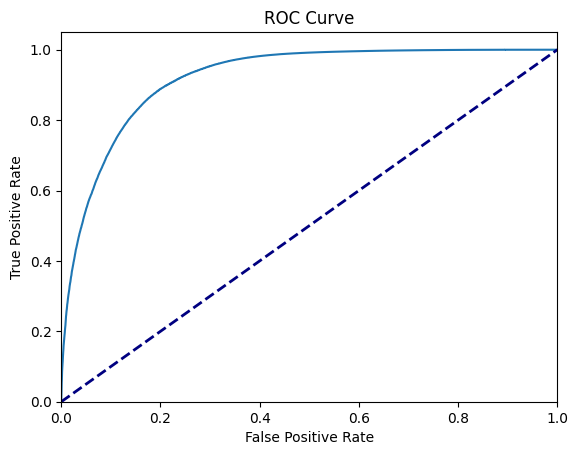

`Trainer.fit` stopped: `max_epochs=10` reached.


         Validation epoch=9          
┏━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric        ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ BCELoss       │ 0.12600 │ 0.00232 │
│ BCELoss_train │ 0.12662 │     nan │
│ val_accuracy  │ 0.96064 │     nan │
│ val_recall    │ 0.99087 │     nan │
└───────────────┴─────────┴─────────┘



In [31]:
max_epochs = 10

trainer = Trainer(max_epochs=max_epochs, accelerator="gpu",
                  log_every_n_steps=1, callbacks=[PrintValidationMetrics(),
                                                  TQDMProgressBar(refresh_rate=5)])

trainer.fit(model=nmodel, datamodule=dm)

In [ ]:
# 0.9340 0.9359